Overwriting on directory .
visibility----------- [True, True, True, True, True, True]


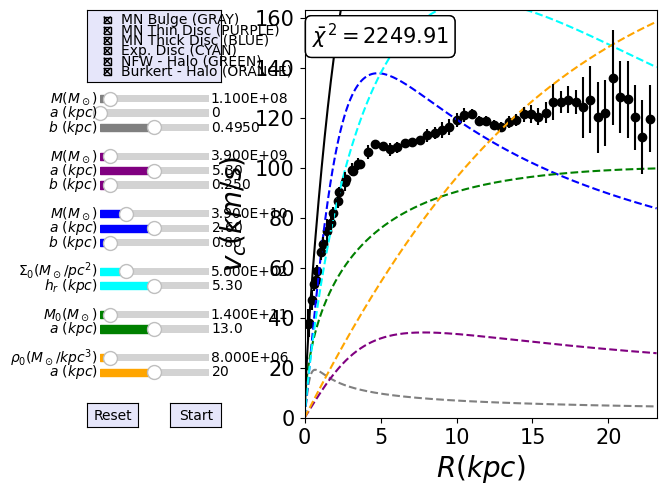


#####################################################################
######################         GalRotpy        ######################
#####################################################################


Dimension:  14

#####################################################################


Running...



100%|██████████| 100/100 [03:52<00:00,  2.32s/it]


It took  3.905666184425354 minutes

#####################################################################



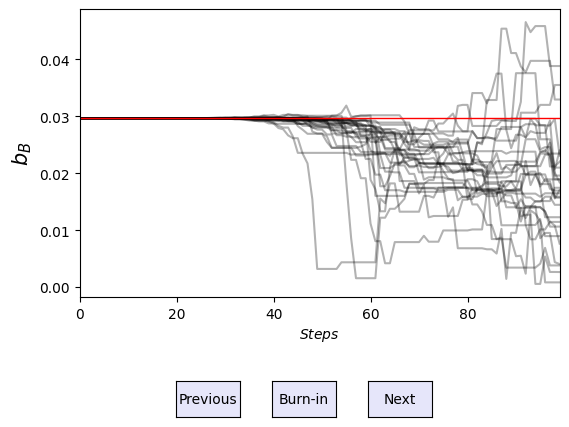


#####################################################################

Plotting...

#####################################################################

                       PARAMETER        UNITS              95%(-)  \
BULGE                          b          kpc            0.020948   
---                            M        M_Sun      3668901.703181   
THIN DISK                      a          kpc            0.060981   
---                            b          kpc            0.032757   
---                            M        M_Sun    576094174.973022   
THICK DISK                     a          kpc            0.022555   
---                            b          kpc            0.187827   
---                            M        M_Sun   8349166212.879257   
EXPONENTIAL DISK             h_r          kpc            0.191675   
---                      Sigma_0   M_Sun/pc^2          101.245985   
---                            M        M_Sun   1006371186.545324   
NFW HALO        

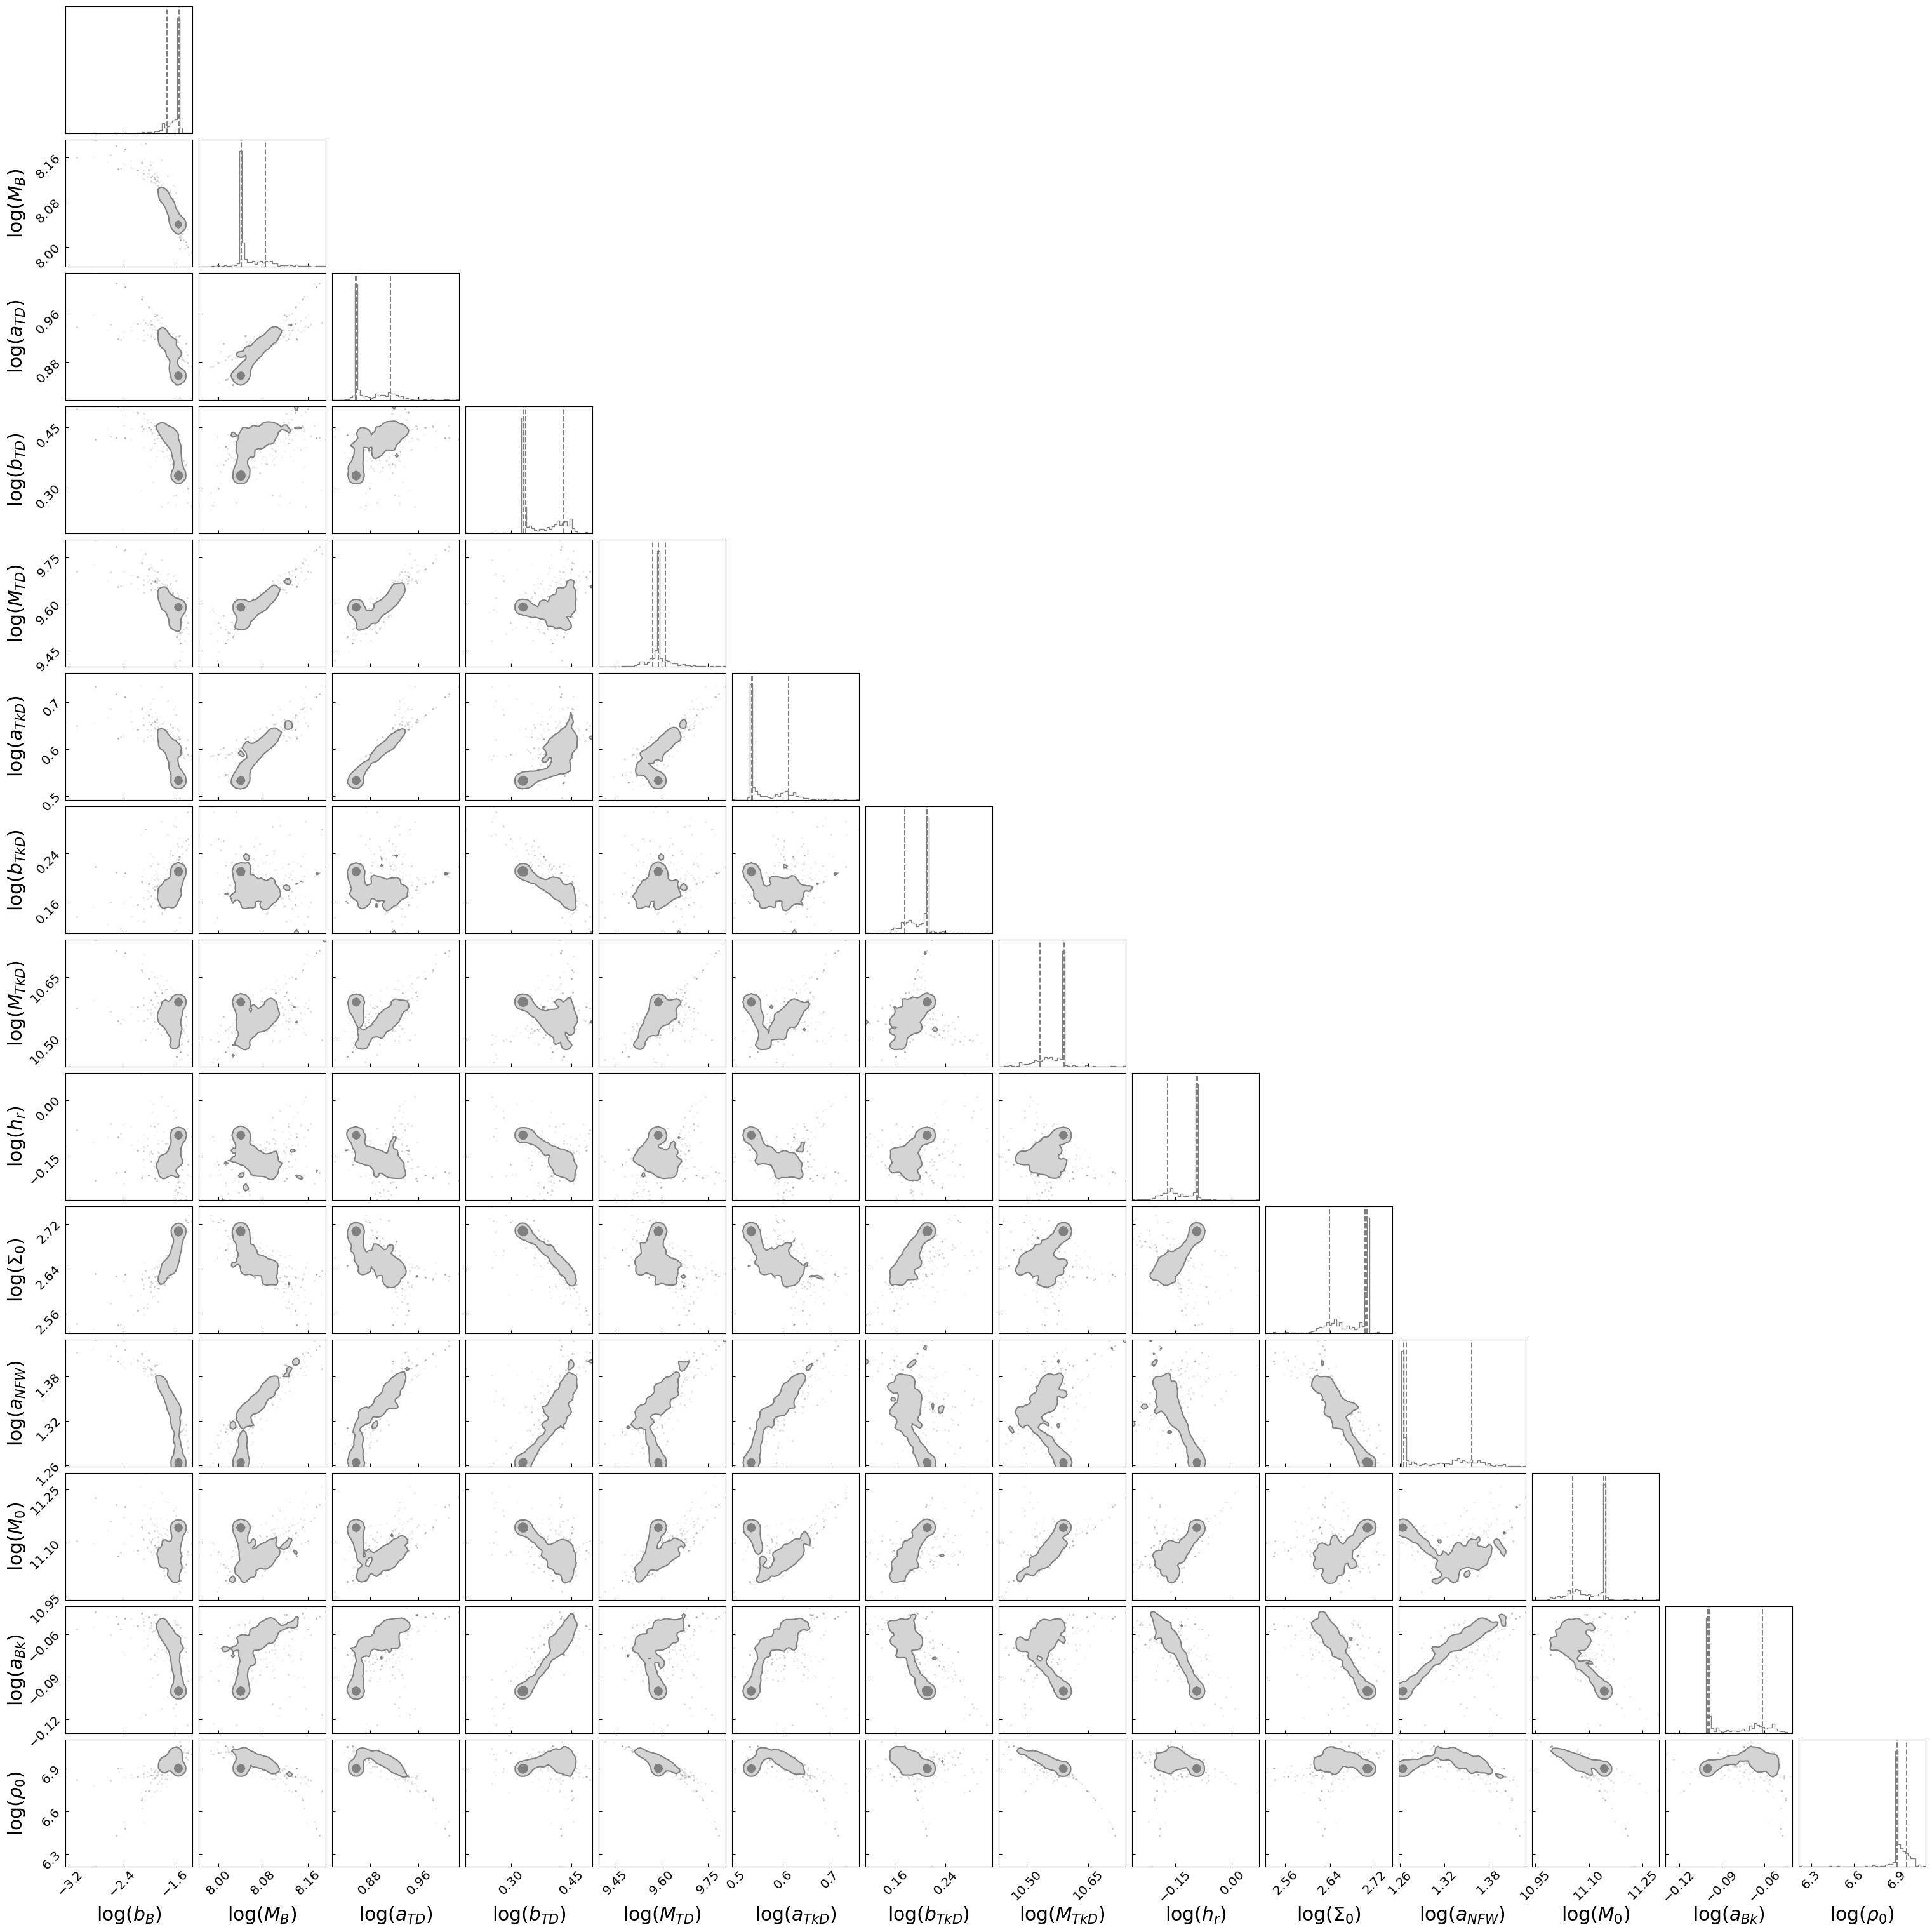

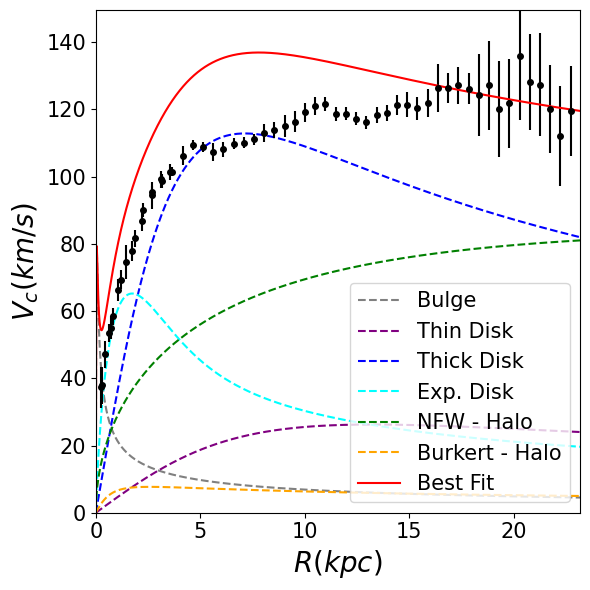

In [16]:
file_path = 'M33_rot_curve.txt'  # nombre del archivo subido

rot_curve_file = file_path
guess_table = 'init_guess_params.txt'
out_folder = '.'
optional_potentials = {'bulge', 'disk', 'halo'}
z = 0.0
Delta_c = None
nwalkers = None
steps = 100
Round = 1
burn_in = 1

from matplotlib.widgets import Slider, Button, RadioButtons, CheckButtons, TextBox # Matplotlib widgets
import matplotlib.pylab as plt # Plotting interface
import numpy as np # Array managing
from galpy.potential import MiyamotoNagaiPotential, NFWPotential, RazorThinExponentialDiskPotential, BurkertPotential # GALPY potentials
from galpy.potential import calcRotcurve # composed rotation curve calculation for plotting
from astropy import units # Physical/real units data managing
from astropy import table as Table # For fast and easy reading / writing with tables using numpy library
import emcee
import corner
import time
import pandas as pd
import multiprocessing as mp
from scipy.optimize import fsolve, minimize, curve_fit
from multiprocessing import Pool
import sys
import os
import warnings


ALLOWED_OPTIONS = [{'bulge', 'halo'}, {'disk', 'halo'}, {'bulge', 'disk', 'halo'}]
ALLOWED_POTENTIALS = ["bulge", "disk", "thickDisk", "expDisk", "halo", "burkert"]


warnings.filterwarnings('ignore')



def boolString_to_bool(boolString):
    if boolString == 'True':
        return True
    elif boolString == 'False':
        return False
    else:
        return None

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Initial parameters and arguments parsing:

# rot_curve_file = None
has_gui = False
has_guess = False
guess_table = 'init_guess_params.txt'
out_folder = '.'

optional_potentials = set()

warnings_args = []

# complete_args = sys.argv
# print("complete_args-------", complete_args)
# for (i, arg) in enumerate(complete_args):
#     print(arg)
#     if i == 1:
#         rot_curve_file = arg
#         warnings_args.append("Using '"+rot_curve_file+"' as the rotation curve file.")
#     if ('--gui' == arg) and (i > 1):
#         has_gui = has_gui or True
#     if '--guess' in arg:
#         guess_arg = arg.split(sep='=')
#         if len(guess_arg) == 2:
#             guess_table = guess_arg[-1]
#             has_guess = has_guess or True
#         if len(optional_potentials) > 0:
#             warnings_args.append("You will use '--guess' option but some potentials ('bulge', 'disk' or 'halo') are in your args too. There will be used the guess txt file.")

#     if '--outfolder' in arg:
#         outfolder_arg = arg.split(sep='=')
#         if len(outfolder_arg) == 2:
#             out_folder = './'+outfolder_arg[-1]
#             warnings_args.append("Saving output files into %s folder" % out_folder)

#     if 'bulge' == arg:
#         optional_potentials.add('bulge')
#     if 'disk' == arg:
#         optional_potentials.add('disk')
#     if 'halo' == arg:
#         optional_potentials.add('halo')

if len(warnings_args) > 0:
    print("Warning: ", warnings_args)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Create a directory to save all outputs
try:
    os.mkdir(out_folder)
except FileExistsError:
    print ("Overwriting on directory %s" % out_folder)
except OSError:
    print ("Creation of the directory %s failed" % out_folder)
else:
    print ("Successfully created the directory %s " % out_folder)
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


try:
    if rot_curve_file is None:
        raise Exception('Error: Rotation curve file not specified in GalRotpy arguments')
    else:
        tt=Table.Table.read(rot_curve_file, format='ascii.tab') # Rotation curve
except Exception as error:
    print(error)
    #sys.exit()
    raise Exception('Archivo no válido. Ejecución detenida.')

except:
    print("Error: Rotation curve file ", rot_curve_file," not readable or corrupt. Please read the documentation for rotation file specifications.")
    #sys.exit()
    raise Exception('Archivo no válido. Ejecución detenida.')


x_offset = 0.0  # It defines a radial coordinate offset as user input
r_0=1*units.kpc # units
v_0=220*units.km/units.s # units

# Real data:
r_data=tt['r']-x_offset # The txt file must contain the radial coordinate values in kpc
v_c_data=tt['vel'] # velocity in km/s
v_c_err_data = tt['e_vel'] # and velocity error in km/s
N_data = len(r_data)
# This loop is needed since galpy fails when r=0 or very close to 0
for i in range(len(r_data)):
    if r_data[i]<1e-3:
        r_data[i]=1e-3

def Bulge_NFW_potentials( r, delta_r, bulge_amp, bulge_a, bulge_b, dark_halo_amp, dark_halo_a ):
    r_0=1*units.kpc # units
    v_0=220*units.km/units.s # units

    MN_Bulge_p= MiyamotoNagaiPotential(amp=bulge_amp*units.Msun,
                                       a=bulge_a*units.kpc,
                                       b=bulge_b*units.kpc,
                                       normalize=False,
                                       ro=r_0, vo=v_0)
    NFW_p = NFWPotential(amp=dark_halo_amp*units.Msun,
                         a=dark_halo_a*units.kpc,
                         normalize=False,
                         ro=r_0, vo=v_0)

    v_circ_comp = calcRotcurve([MN_Bulge_p, NFW_p], r-delta_r , phi=None)*220
    return v_circ_comp

def Bulge_ThinDisk_NFW_potentials( r, delta_r, bulge_amp, bulge_a, bulge_b, tn_amp, tn_a, tn_b, dark_halo_amp, dark_halo_a ):
    r_0=1*units.kpc # units
    v_0=220*units.km/units.s # units

    MN_Bulge_p= MiyamotoNagaiPotential(amp=bulge_amp*units.Msun,
                                       a=bulge_a*units.kpc,
                                       b=bulge_b*units.kpc,
                                       normalize=False,
                                       ro=r_0, vo=v_0)
    MN_Thin_Disk_p= MiyamotoNagaiPotential(amp=tn_amp*units.Msun,
                                       a=tn_a*units.kpc,
                                       b=tn_b*units.kpc,
                                       normalize=False,
                                       ro=r_0, vo=v_0)
    NFW_p = NFWPotential(amp=dark_halo_amp*units.Msun,
                         a=dark_halo_a*units.kpc,
                         normalize=False,
                         ro=r_0, vo=v_0)

    v_circ_comp = calcRotcurve([MN_Bulge_p, MN_Thin_Disk_p, NFW_p], r-delta_r , phi=None)*220
    return v_circ_comp

def ThinDisk_NFW_potentials( r, delta_r, tn_amp, tn_a, tn_b, dark_halo_amp, dark_halo_a ):
    r_0=1*units.kpc # units
    v_0=220*units.km/units.s # units

    MN_Thin_Disk_p= MiyamotoNagaiPotential(amp=tn_amp*units.Msun,
                                       a=tn_a*units.kpc,
                                       b=tn_b*units.kpc,
                                       normalize=False,
                                       ro=r_0, vo=v_0)
    NFW_p = NFWPotential(amp=dark_halo_amp*units.Msun,
                         a=dark_halo_a*units.kpc,
                         normalize=False,
                         ro=r_0, vo=v_0)

    v_circ_comp = calcRotcurve([ MN_Thin_Disk_p, NFW_p], r-delta_r , phi=None)*220
    return v_circ_comp


data_rows = [('BULGE', 110000000.0, 1.0, 0.0, 20, 0.495, 70),
             ('THIN DISK', 3900000000.0, 1.0, 5.3, 90, 0.25, 1),
             ('THICK DISK', 39000000000.0, 0.5, 2.6, 20, 0.8, 1),
             ('EXP DISK', 500.0, 0.5, 5.3, 90, 0.0, 0),
             ('DARK HALO', 140000000000.0, 1.0, 13.0, 90, 0.0, 0),
             ('BURKERT HALO', 8000000.0, 1.0, 20.0, 90, 0.0, 0)]
input_params = Table.Table(rows=data_rows, names=('component', 'mass', 'threshold_mass', 'a (kpc)', 'threshold_a', 'b (kpc)', 'threshold_b'))

c_bulge, amp1, delta_mass_bulge, a1, delta_radial_bulge, b1, delta_vertical_bulge, include_bulge = *input_params[0], True
c_tn, amp2, delta_mass_tn, a2, delta_radial_tn, b2, delta_vertical_tn, include_tn = *input_params[1], True
c_tk, amp3, delta_mass_tk, a3, delta_radial_tk, b3, delta_vertical_tk, include_tk = *input_params[2], True
c_ex, amp4, delta_mass_ex, h_r, delta_radial_ex, vertical_ex, delta_vertical_ex, include_ex = *input_params[3], True
c_dh, amp5, delta_mass_dh, a5, delta_radial_dh, b5, delta_vertical_dh, include_dh = *input_params[4], True
c_bh, amp6, delta_mass_bh, a6, delta_radial_bh, b6, delta_vertical_bh, include_bh = *input_params[5], True

visibility = [include_bulge, include_tn, include_tk, include_ex, include_dh, include_bh]

if has_guess:
    print('Using guess table', guess_table)
    try:
        init_guess_params = Table.Table.read(guess_table, format='ascii.tab')

        c_bulge, amp1, a1, b1, include_bulge = init_guess_params[0]
        c_tn, amp2, a2, b2, include_tn = init_guess_params[1]
        c_tk, amp3, a3, b3, include_tk = init_guess_params[2]
        c_ex, amp4, h_r, vertical_ex, include_ex = init_guess_params[3]
        c_dh, amp5, a5, b5, include_dh = init_guess_params[4]
        c_bh, amp6, a6, b6, include_bh = init_guess_params[5]
        visibility = [ boolString_to_bool(include_bulge), boolString_to_bool(include_tn), boolString_to_bool(include_tk), boolString_to_bool(include_ex), boolString_to_bool(include_dh), boolString_to_bool(include_bh)]
    except:
        print("Error: Guess file ", guess_table," not readable or corrupt. Please read the documentation for rotation file specifications.")
        sys.exit()

elif optional_potentials in ALLOWED_OPTIONS:
    print('Using optional potentials', optional_potentials)
    for (i, potential) in enumerate(ALLOWED_POTENTIALS):
        if potential in optional_potentials:
            visibility[i] = True
        else:
            visibility[i] = False

    if optional_potentials == ALLOWED_OPTIONS[0]:
        bounds = (( -10, amp1/(10**delta_mass_bulge), a1, b1*(1-0.01*delta_vertical_bulge), amp5/(10*delta_mass_dh), a5*(1-0.01*delta_radial_dh)  ),
                (  10, amp1*(10**delta_mass_bulge), 0.1*delta_radial_bulge,  b1*(1+0.01*delta_vertical_bulge), amp5*(10**delta_mass_dh), a5*(1+0.01*delta_radial_dh)  ) )

        popt, pcov = curve_fit(Bulge_NFW_potentials,
                    r_data, v_c_data.data,
                    p0=[x_offset, amp1, a1, b1, amp5, a5 ],
                    bounds=bounds )
        x_offset, amp1, a1, b1, amp5, a5 = popt
    if optional_potentials == ALLOWED_OPTIONS[2]:
        bounds = (( -10, amp1/(10**delta_mass_bulge), a1, b1*(1-0.01*delta_vertical_bulge), amp2/(10**delta_mass_tn), a2*(1-0.01*delta_radial_tn), b2/(10**delta_vertical_tn), amp5/(10*delta_mass_dh), a5*(1-0.01*delta_radial_dh)  ),
                (  10, amp1*(10**delta_mass_bulge), 0.1*delta_radial_bulge,  b1*(1+0.01*delta_vertical_bulge), amp2*(10**delta_mass_tn), a2*(1+0.01*delta_radial_tn), b2*(10**delta_vertical_tn), amp5*(10**delta_mass_dh), a5*(1+0.01*delta_radial_dh)  ) )

        popt, pcov = curve_fit(Bulge_ThinDisk_NFW_potentials,
                    r_data, v_c_data.data,
                    p0=[x_offset, amp1, a1, b1, amp2, a2, b2, amp5, a5 ],
                    bounds=bounds )
        x_offset, amp1, a1, b1, amp2, a2, b2, amp5, a5 = popt
    if optional_potentials == ALLOWED_OPTIONS[1]:
        bounds = (( -10, amp2/(10**delta_mass_tn), a2*(1-0.01*delta_radial_tn), b2/(10**delta_vertical_tn), amp5/(10*delta_mass_dh), a5*(1-0.01*delta_radial_dh)  ),
                (  10, amp2*(10**delta_mass_tn), a2*(1+0.01*delta_radial_tn), b2*(10**delta_vertical_tn), amp5*(10**delta_mass_dh), a5*(1+0.01*delta_radial_dh)  ) )

        popt, pcov = curve_fit(ThinDisk_NFW_potentials,
                    r_data, v_c_data.data,
                    p0=[x_offset,  amp2, a2, b2, amp5, a5 ],
                    bounds=bounds )
        x_offset, amp2, a2, b2, amp5, a5 = popt


print("visibility-----------", visibility)

#HHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHH
#HHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHH

# PART 1: Base code

#HHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHH
#HHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHH


#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Chi^2
def chi2(curves):
    rc = calcRotcurve(curves, r_data, phi=None)*220
    x2 = np.sum(((v_c_data-rc)/v_c_err_data)**2)
    return x2
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Here we calculate de rotation curve for each of the potentials used

lista=np.linspace(0.001, 1.02*np.max(r_data), 10*len(r_data)) # radial coordinate for the rotation curve calculation

# Potentials definition using physical units (amplitude in Solar masses, scales in kpc and surface density in Solar masses / pc^2 )
MN_Bulge_p= MiyamotoNagaiPotential(amp=amp1*units.Msun,a=a1*units.kpc,b=b1*units.kpc,normalize=False,ro=r_0, vo=v_0)
MN_Thin_Disk_p= MiyamotoNagaiPotential(amp=amp2*units.Msun,a=a2*units.kpc,b=b2*units.kpc,normalize=False,ro=r_0, vo=v_0)
MN_Thick_Disk_p= MiyamotoNagaiPotential(amp=amp3*units.Msun,a=a3*units.kpc,b=b3*units.kpc,normalize=False,ro=r_0, vo=v_0)
EX_Disk_p = RazorThinExponentialDiskPotential(amp=amp4*(units.Msun/(units.pc**2)), hr=h_r*units.kpc, normalize=False, ro=r_0, vo=v_0, new=True, glorder=100)
NFW_p = NFWPotential(amp=amp5*units.Msun, a=a5*units.kpc, normalize=False, ro=r_0, vo=v_0)
BK_p = BurkertPotential(amp=amp6*units.Msun/(units.kpc)**3, a=a6*units.kpc, normalize=False, ro=r_0, vo=v_0)

# Circular velocities in km/s
MN_Bulge = calcRotcurve(MN_Bulge_p, lista, phi=None)*220
MN_Thin_Disk = calcRotcurve(MN_Thin_Disk_p, lista, phi=None)*220
MN_Thick_Disk = calcRotcurve(MN_Thick_Disk_p, lista, phi=None)*220
EX_Disk = calcRotcurve(EX_Disk_p, lista, phi=None)*220
NFW = calcRotcurve(NFW_p, lista, phi=None)*220
BK = calcRotcurve(BK_p, lista, phi=None)*220

# Circular velocity for the composition of 5 potentials in km/s
v_circ_comp = calcRotcurve([MN_Bulge_p,MN_Thin_Disk_p,MN_Thick_Disk_p, EX_Disk_p, NFW_p, BK_p], lista, phi=None)*220

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Here we plot the different curves

fig = plt.figure(1)
ax = fig.add_axes((0.41, 0.1, 0.55, 0.85))

#ax.yaxis.set_ticks_position('both')
#ax.tick_params(axis='y', which='both', labelleft=True, labelright=True)

# Data
CV_galaxy = ax.errorbar(r_data - x_offset, v_c_data, v_c_err_data,  c='k', fmt='', ls='none')
CV_galaxy_dot = ax.scatter(r_data - x_offset, v_c_data, c='k')

# A plot for each rotation curve with the colors indicated below
MN_b_plot, = ax.plot(lista, MN_Bulge, linestyle='--', c='gray')
MN_td_plot, = ax.plot(lista, MN_Thin_Disk, linestyle='--', c='purple')
MN_tkd_plot, = ax.plot(lista, MN_Thick_Disk, linestyle='--', c='blue')
EX_d_plot, = ax.plot(lista, EX_Disk, linestyle='--', c='cyan')
NFW_plot, = ax.plot(lista, NFW, linestyle='--', c='green')
BK_plot, = ax.plot(lista, BK, linestyle='--', c='orange')

# Composed rotation curve

v_circ_comp_plot, = ax.plot(lista, v_circ_comp, c='k')


#HHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHH
#HHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHH

# PART 2: Interactive(Slides) code

#HHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHH
#HHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHH

# Checkbox for selecting the potentials to compose the rotation
rax = plt.axes((0.07, 0.8, 0.21, 0.15))
check = CheckButtons(rax,
    ('MN Bulge (GRAY)', 'MN Thin Disc (PURPLE)', 'MN Thick Disc (BLUE)',
     'Exp. Disc (CYAN)', 'NFW - Halo (GREEN)', 'Burkert - Halo (ORANGE)'),
    visibility)

rax.set_facecolor("lavender")  # Fondo claro

# Opcional: estilizar texto
for label in check.labels:
    label.set_fontsize(10)
    label.set_color("black")


#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Here we define the funcion which update the rotation curve for the selected and the composed potential
def update_rot_curve():
    ax.clear()
    global check, MN_b_plot, MN_Bulge_p, MN_Thin_Disk_p,MN_Thick_Disk_p, MN_td_plot,MN_tkd_plot, NFW_p, NFW_plot, EX_d_plot, EX_Disk_p, CV_galaxy, CV_galaxy_dot, BK_p, BK_plot
    composite_pot_array=[]
    ax.set_xlabel(r'$R(kpc)$', fontsize=20)
    ax.set_ylabel(r'$v_c(km/s)$', fontsize=20)
    ax.tick_params(axis='both', which='both', labelsize=15)
    ax.set_xlim([0, np.max(lista)])
    ax.set_ylim([0,np.max(v_c_data)*1.2])

    check_visibility = check.get_status()
    MN_b_plot.set_visible(check_visibility[0])
    MN_td_plot.set_visible(check_visibility[1])
    MN_tkd_plot.set_visible(check_visibility[2])
    EX_d_plot.set_visible(check_visibility[3])
    NFW_plot.set_visible(check_visibility[4])
    BK_plot.set_visible(check_visibility[5])

    N = []
    if MN_b_plot.get_visible() == True:
        if a1 ==0.: N.append(2)
        else:       N.append(3)
        MN_Bulge = calcRotcurve(MN_Bulge_p, lista, phi=None)*220
        MN_b_plot, = ax.plot(lista, MN_Bulge, linestyle='--', c='gray')
        composite_pot_array.append(MN_Bulge_p)
    if MN_td_plot.get_visible() == True:
        N.append(3)
        MN_Thin_Disk = calcRotcurve(MN_Thin_Disk_p, lista, phi=None)*220
        MN_td_plot, = ax.plot(lista, MN_Thin_Disk, linestyle='--', c='purple')
        composite_pot_array.append(MN_Thin_Disk_p)
    if MN_tkd_plot.get_visible() == True:
        N.append(3)
        MN_Thick_Disk = calcRotcurve(MN_Thick_Disk_p, lista, phi=None)*220
        MN_tkd_plot, = ax.plot(lista, MN_Thick_Disk, linestyle='--', c='blue')
        composite_pot_array.append(MN_Thick_Disk_p)
    if NFW_plot.get_visible() == True:
        N.append(2)
        NFW = calcRotcurve(NFW_p, lista, phi=None)*220
        NFW_plot, = ax.plot(lista, NFW, linestyle='--', c='green')
        composite_pot_array.append(NFW_p)
    if EX_d_plot.get_visible() == True:
        N.append(2)
        EX_Disk = calcRotcurve(EX_Disk_p, lista, phi=None)*220
        EX_d_plot, = ax.plot(lista, EX_Disk, linestyle='--', c='cyan')
        composite_pot_array.append(EX_Disk_p)
    if BK_plot.get_visible() == True:
        N.append(2)
        BK = calcRotcurve(BK_p, lista, phi=None)*220
        BK_plot, = ax.plot(lista, BK, linestyle='--', c='orange')
        composite_pot_array.append(BK_p)
    DIM = np.sum(N)
    CHI2 = chi2(composite_pot_array)
    props = dict(boxstyle='round', facecolor='white')
    ax.text(0.02, 0.97, r"$\bar\chi^2={:.2f}$".format(CHI2/(N_data - DIM)), transform=ax.transAxes, fontsize=15, verticalalignment='top', bbox=props)
    CV_galaxy = ax.errorbar(r_data - x_offset, v_c_data, v_c_err_data,  c='k', fmt='', ls='none')
    CV_galaxy_dot = ax.scatter(r_data - x_offset, v_c_data, c='k')
    v_circ_comp = calcRotcurve(composite_pot_array, lista, phi=None)*220
    v_circ_comp_plot, = ax.plot(lista, v_circ_comp, c='k')

ax.set_xlabel(r'$R(kpc)$', fontsize=20)
ax.set_ylabel(r'$v_c(km/s)$', fontsize=20)
ax.tick_params(axis='both', which='both', labelsize=15)

update_rot_curve()

#HHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHH
#HHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHH

# PART 2: Interactive(Slides) code

#HHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHH
#HHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHH

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Here we define the sliders for each potential

# Bulge - gray
MN_b_amp_ax = fig.add_axes((0.09,0.75,0.17,0.03))
MN_b_amp_s = Slider(MN_b_amp_ax, r"$M$($M_\odot$)", amp1/(10**delta_mass_bulge), amp1*(10**delta_mass_bulge), valinit=amp1, color='gray', valfmt='%1.3E')
MN_b_a_ax = fig.add_axes((0.09,0.72,0.17,0.03))
MN_b_a_s = Slider(MN_b_a_ax, "$a$ ($kpc$)", 0, 0.1*delta_radial_bulge, valinit=a1, color='gray')
MN_b_b_ax = fig.add_axes((0.09,0.69,0.17,0.03))
MN_b_b_s = Slider(MN_b_b_ax, "$b$ ($kpc$)", b1*(1-0.01*delta_vertical_bulge), b1*(1+0.01*delta_vertical_bulge), valinit=b1, color='gray')

# Thin disk - purple
MN_td_amp_ax = fig.add_axes((0.09,0.63,0.17,0.03))
MN_td_amp_s = Slider(MN_td_amp_ax, r"$M$($M_\odot$)", amp2/(10**delta_mass_tn), amp2*(10**delta_mass_tn), valinit=amp2, color='purple', valfmt='%1.3E')
MN_td_a_ax = fig.add_axes((0.09,0.60,0.17,0.03))
MN_td_a_s = Slider(MN_td_a_ax, "$a$ ($kpc$)", a2*(1-0.01*delta_radial_tn), a2*(1+0.01*delta_radial_tn), valinit=a2, color='purple')
MN_td_b_ax = fig.add_axes((0.09,0.57,0.17,0.03))
MN_td_b_s = Slider(MN_td_b_ax, "$b$ ($kpc$)", b2/(10**delta_vertical_tn), b2*(10**delta_vertical_tn), valinit=b2, color='purple')

# Thick disk - Blue
MN_tkd_amp_ax = fig.add_axes((0.09,0.51,0.17,0.03))
MN_tkd_amp_s = Slider(MN_tkd_amp_ax, r"$M$($M_\odot$)", amp3/(10**delta_mass_tk), amp3*(10**delta_mass_tk), valinit=amp3, color='blue', valfmt='%1.3E')
MN_tkd_a_ax = fig.add_axes((0.09,0.48,0.17,0.03))
MN_tkd_a_s = Slider(MN_tkd_a_ax, "$a$ ($kpc$)", a3*(1-0.01*delta_radial_tk), a3*(1+0.01*delta_radial_tk), valinit=a3, color='blue')
MN_tkd_b_ax = fig.add_axes((0.09,0.45,0.17,0.03))
MN_tkd_b_s = Slider(MN_tkd_b_ax, "$b$ ($kpc$)", b3/(10**delta_vertical_tk), b3*(10**delta_vertical_tk), valinit=b3, color='blue')

# Exponential disk - Cyan
MN_ed_amp_ax = fig.add_axes((0.09,0.39,0.17,0.03))
MN_ed_amp_s = Slider(MN_ed_amp_ax, r"$\Sigma_0$($M_\odot/pc^2$)", amp4/(10**delta_mass_ex), amp4*(10**delta_mass_ex), valinit=amp4, color='cyan', valfmt='%1.3E')
MN_ed_a_ax = fig.add_axes((0.09,0.36,0.17,0.03))
MN_ed_a_s = Slider(MN_ed_a_ax, "$h_r$ ($kpc$)", h_r*(1-0.01*delta_radial_ex), h_r*(1+0.01*delta_radial_ex), valinit=h_r, color='cyan')

# NFW Halo - green
NFW_amp_ax = fig.add_axes((0.09,0.30,0.17,0.03))
NFW_amp_s = Slider(NFW_amp_ax, r"$M_0$($M_\odot$)", amp5/(10*delta_mass_dh), amp5*(10**delta_mass_dh), valinit=amp5, color='green', valfmt='%1.3E')
NFW_a_ax = fig.add_axes((0.09,0.27,0.17,0.03))
NFW_a_s = Slider(NFW_a_ax, "$a$ ($kpc$)", a5*(1-0.01*delta_radial_dh), a5*(1+0.01*delta_radial_dh), valinit=a5, color='green')

# Burkert Halo - orange
BK_amp_ax = fig.add_axes((0.09,0.21,0.17,0.03))
BK_amp_s = Slider(BK_amp_ax, r"$\rho_0$($M_\odot/kpc^3$)", amp6/(10*delta_mass_bh), amp6*(10**delta_mass_bh), valinit=amp6, color='orange', valfmt='%1.3E')
BK_a_ax = fig.add_axes((0.09,0.18,0.17,0.03))
BK_a_s = Slider(BK_a_ax, "$a$ ($kpc$)", a6*(1-0.01*delta_radial_bh), a6*(1+0.01*delta_radial_bh), valinit=a6, color='orange')

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Here we define the function for setting new parameters for each potential

# Bulge
def MN_b_amp_s_func(val):
    if MN_b_plot.get_visible() == True:
        global MN_Bulge_p, amp1, a1, b1
        amp1=val*1
        MN_Bulge_p = MiyamotoNagaiPotential(amp=val*units.Msun,a=a1*units.kpc,b=b1*units.kpc,normalize=False,ro=r_0, vo=v_0)
        update_rot_curve()
def MN_b_a_s_func(val):
    if MN_b_plot.get_visible() == True:
        global MN_Bulge_p, amp1, a1, b1
        a1=val*1
        MN_Bulge_p = MiyamotoNagaiPotential(amp=amp1*units.Msun,a=val*units.kpc,b=b1*units.kpc,normalize=False,ro=r_0, vo=v_0)
        update_rot_curve()
def MN_b_b_s_func(val):
    if MN_b_plot.get_visible() == True:
        global MN_Bulge_p, amp1, a1, b1
        b1=val*1
        MN_Bulge_p = MiyamotoNagaiPotential(amp=amp1*units.Msun,a=a1*units.kpc,b=val*units.kpc,normalize=False,ro=r_0, vo=v_0)
        update_rot_curve()

# Thin disk
def MN_td_amp_s_func(val):
    if MN_td_plot.get_visible() == True:
        global MN_Thin_Disk_p, amp2, a2, b2
        amp2=val*1
        MN_Thin_Disk_p= MiyamotoNagaiPotential(amp=val*units.Msun,a=a2*units.kpc,b=b2*units.kpc,normalize=False,ro=r_0, vo=v_0)
        update_rot_curve()
def MN_td_a_s_func(val):
    if MN_td_plot.get_visible() == True:
        global MN_Thin_Disk_p, amp2, a2, b2
        a2=val*1
        MN_Thin_Disk_p= MiyamotoNagaiPotential(amp=amp2*units.Msun,a=val*units.kpc,b=b2*units.kpc,normalize=False,ro=r_0, vo=v_0)
        update_rot_curve()
def MN_td_b_s_func(val):
    if MN_td_plot.get_visible() == True:
        global MN_Thin_Disk_p, amp2, a2, b2
        b2=val*1
        MN_Thin_Disk_p= MiyamotoNagaiPotential(amp=amp2*units.Msun,a=a2*units.kpc,b=val*units.kpc,normalize=False,ro=r_0, vo=v_0)
        update_rot_curve()

# Thick disk
def MN_tkd_amp_s_func(val):
    if MN_tkd_plot.get_visible() == True:
        global MN_Thick_Disk_p, amp3, a3, b3
        amp3=val*1
        MN_Thick_Disk_p= MiyamotoNagaiPotential(amp=val*units.Msun,a=a3*units.kpc,b=b3*units.kpc,normalize=False,ro=r_0, vo=v_0)
        update_rot_curve()
def MN_tkd_a_s_func(val):
    if MN_tkd_plot.get_visible() == True:
        global MN_Thick_Disk_p, amp3, a3, b3
        a3=val*1
        MN_Thick_Disk_p= MiyamotoNagaiPotential(amp=amp3*units.Msun,a=val*units.kpc,b=b3*units.kpc,normalize=False,ro=r_0, vo=v_0)
        update_rot_curve()
def MN_tkd_b_s_func(val):
    if MN_tkd_plot.get_visible() == True:
        global MN_Thick_Disk_p, amp3, a3, b3
        b3=val*1
        MN_Thick_Disk_p= MiyamotoNagaiPotential(amp=amp3*units.Msun,a=a3*units.kpc,b=val*units.kpc,normalize=False,ro=r_0, vo=v_0)
        update_rot_curve()

# Exponential disk
def MN_ed_amp_s_func(val):
    if EX_d_plot.get_visible() == True:
        global EX_Disk_p, amp4,h_r
        amp4=val*1
        EX_Disk_p = RazorThinExponentialDiskPotential(amp=val*(units.Msun/(units.pc**2)), hr=h_r*units.kpc, maxiter=20, tol=0.001, normalize=False, ro=r_0, vo=v_0, new=True, glorder=100)
        update_rot_curve()
def MN_ed_a_s_func(val):
    if EX_d_plot.get_visible() == True:
        global EX_Disk_p, amp4,h_r
        h_r=val*1
        EX_Disk_p = RazorThinExponentialDiskPotential(amp=amp4*(units.Msun/(units.pc**2)), hr=val*units.kpc, maxiter=20, tol=0.001, normalize=False, ro=r_0, vo=v_0, new=True, glorder=100)
        update_rot_curve()

# NFW Halo
def NFW_amp_s_func(val):
    if NFW_plot.get_visible() == True:
        global NFW_p, amp5,a5
        amp5=val*1
        NFW_p = NFWPotential(amp=val*units.Msun, a=a5*units.kpc, normalize=False, ro=r_0, vo=v_0)
        update_rot_curve()
def NFW_a_s_func(val):
    if NFW_plot.get_visible() == True:
        global NFW_p, amp5,a5
        a5=val*1
        NFW_p = NFWPotential(amp=amp5*units.Msun, a=val*units.kpc, normalize=False, ro=r_0, vo=v_0)
        update_rot_curve()

# Burkert Halo
def BK_amp_s_func(val):
    if BK_plot.get_visible() == True:
        global BK_p, amp6,a6
        amp6=val*1
        BK_p = BurkertPotential(amp=val*units.Msun/(units.kpc)**3, a=a6*units.kpc, normalize=False, ro=r_0, vo=v_0)
        update_rot_curve()
def BK_a_s_func(val):
    if BK_plot.get_visible() == True:
        global BK_p, amp6,a6
        a6=val*1
        BK_p = BurkertPotential(amp=amp6*units.Msun/(units.kpc)**3, a=val*units.kpc, normalize=False, ro=r_0, vo=v_0)
        update_rot_curve()



#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Here we define the sliders update functions
MN_b_amp_s.on_changed(MN_b_amp_s_func)
MN_b_a_s.on_changed(MN_b_a_s_func)
MN_b_b_s.on_changed(MN_b_b_s_func)
MN_td_amp_s.on_changed(MN_td_amp_s_func)
MN_td_a_s.on_changed(MN_td_a_s_func)
MN_td_b_s.on_changed(MN_td_b_s_func)
MN_tkd_amp_s.on_changed(MN_tkd_amp_s_func)
MN_tkd_a_s.on_changed(MN_tkd_a_s_func)
MN_tkd_b_s.on_changed(MN_tkd_b_s_func)
NFW_amp_s.on_changed(NFW_amp_s_func)
NFW_a_s.on_changed(NFW_a_s_func)
BK_amp_s.on_changed(BK_amp_s_func)
BK_a_s.on_changed(BK_a_s_func)
MN_ed_amp_s.on_changed(MN_ed_amp_s_func)
MN_ed_a_s.on_changed(MN_ed_a_s_func)
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Here we define the function and create the button which reset the sliders

def reset(event):
    MN_b_amp_s.reset()
    MN_b_a_s.reset()
    MN_b_b_s.reset()
    MN_td_amp_s.reset()
    MN_td_a_s.reset()
    MN_td_b_s.reset()
    MN_tkd_amp_s.reset()
    MN_tkd_a_s.reset()
    MN_tkd_b_s.reset()
    MN_ed_amp_s.reset()
    MN_ed_a_s.reset()
    NFW_amp_s.reset()
    NFW_a_s.reset()
    BK_amp_s.reset()
    BK_a_s.reset()

axcolor="lavender"
resetax = fig.add_axes((0.07, 0.08, 0.08, 0.05))
button_reset = Button(resetax, 'Reset', color=axcolor)
button_reset.on_clicked(reset)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Enable/disable the selected potential for the composed rotation curve

def check_on_clicked(label):

    if label == 'MN Bulge (GRAY)':
        MN_b_plot.set_visible(not MN_b_plot.get_visible())
        update_rot_curve()
    elif label == 'MN Thin Disc (PURPLE)':
        MN_td_plot.set_visible(not MN_td_plot.get_visible())
        update_rot_curve()
    elif label == 'MN Thick Disc (BLUE)':
        MN_tkd_plot.set_visible(not MN_tkd_plot.get_visible())
        update_rot_curve()
    elif label == 'Exp. Disc (CYAN)':
        EX_d_plot.set_visible(not EX_d_plot.get_visible())
        update_rot_curve()
    elif label == 'NFW - Halo (GREEN)':
        NFW_plot.set_visible(not NFW_plot.get_visible())
        update_rot_curve()
    elif label == 'Burkert - Halo (ORANGE)':
        BK_plot.set_visible(not BK_plot.get_visible())
        update_rot_curve()
    plt.draw()


#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Reduced Chi^2

comp = []
N    = 0
if visibility[0] == True:
    comp.append(MN_Bulge_p)
    if a1 == 0.: N += 2
    if a1 != 0.: N += 3
if visibility[1] == True:
    comp.append(MN_Thin_Disk_p)
    N += 3
if visibility[2] == True:
    comp.append(MN_Thick_Disk_p)
    N += 3
if visibility[3] == True:
    comp.append(EX_Disk_p)
    N += 2
if visibility[4] == True:
    comp.append(NFW_p)
    N += 2
if visibility[5] == True:
    comp.append(BK_p)
    N += 2

CHI2 = chi2(comp)
props = dict(boxstyle='round', facecolor='white')
ax.text(0.02, 0.97, r"$\bar\chi^2={:.2f}$".format(CHI2/(N_data - N)), transform=ax.transAxes, fontsize=15, verticalalignment='top', bbox=props)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Plotting all the curves

ax.tick_params(axis='both', which='both', labelsize=15)
ax.set_xlabel(r'$R(kpc)$', fontsize=20)
ax.set_ylabel(r'$v_c(km/s)$', fontsize=20)
ax.tick_params(axis='both', which='both', labelsize=15)
ax.set_xlim([0, np.max(lista)])
ax.set_ylim([0,np.max(v_c_data)*1.2])
check.on_clicked(check_on_clicked)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
"""
Once you click on this button the principal window will close, so you can now enter the number of walkers
and the number of steps you want to use. Take into account that the number of walkers have to be even and at least
twice the dimension of the system (number of parameters to evaluate)
"""
axcolor="lavender"
resetax = fig.add_axes((0.20, 0.08, 0.08, 0.05))
button_start = Button(resetax, 'Start', color=axcolor)

def start(event):
    plt.close('all')

button_start.on_clicked(start)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

plt.show()

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Here we  find the parameters that will be used as initial guess

chk=[]
if MN_b_plot.get_visible() == True:
    chk.append(True)
else:
    chk.append(False)
if MN_td_plot.get_visible() == True:
    chk.append(True)
else:
    chk.append(False)
if MN_tkd_plot.get_visible() == True:
    chk.append(True)
else:
    chk.append(False)
if EX_d_plot.get_visible() == True:
    chk.append(True)
else:
    chk.append(False)
if NFW_plot.get_visible() == True:
    chk.append(True)
else:
    chk.append(False)
if BK_plot.get_visible() == True:
    chk.append(True)
else:
    chk.append(False)

compnts = ['BULGE','THIN DISC','THICK DISC','EXP. DISC', 'DARK HALO', 'BURKERT HALO']
masses = [amp1, amp2, amp3, amp4, amp5, amp6]
aa = [a1, a2, a3, h_r, a5, a6]
bb = [b1, b2, b3, 0, 0, 0]

init_parameters = Table.Table([compnts,masses, aa,bb, chk], names=('component', 'mass', 'a (kpc)', 'b (kpc)', 'checked'))
init_parameters.write(guess_table, format='ascii.tab', overwrite=True)

#HHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHH
#HHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHH

# PART 3: MCMC(Parameters determination) code

#HHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHH
#HHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHH

print ("\n#####################################################################")
print ("######################         GalRotpy        ######################")
print ("#####################################################################\n\n")

def model(parameters, R):
    global  chk, para_labels, aa

    para = {}

    for i in range(len(para_labels)):
        para[para_labels[i]] = parameters[i]

    r_0=1*units.kpc
    v_0=220*units.km/units.s

    check_pot = []

    if chk[0]==True:
        if aa[0]==0.:
            a1=0.
            amp1=para["amp1"]; b1=para["b1"]
        else:
            amp1=para["amp1"]; a1=para["a1"]; b1=para["b1"]

        MN_Bulge_p= MiyamotoNagaiPotential(amp=amp1*units.Msun,a=a1*units.kpc,b=b1*units.kpc,normalize=False,ro=r_0, vo=v_0)
        check_pot.append(MN_Bulge_p)

    if chk[1]==True:
        amp2=para["amp2"]; a2=para["a2"]; b2=para["b2"]
        MN_Thin_Disk_p= MiyamotoNagaiPotential(amp=amp2*units.Msun,a=a2*units.kpc,b=b2*units.kpc,normalize=False,ro=r_0, vo=v_0)
        check_pot.append(MN_Thin_Disk_p)

    if chk[2]==True:
        amp3=para["amp3"]; a3=para["a3"]; b3=para["b3"]
        MN_Thick_Disk_p= MiyamotoNagaiPotential(amp=amp3*units.Msun,a=a3*units.kpc,b=b3*units.kpc,normalize=False,ro=r_0, vo=v_0)
        check_pot.append(MN_Thick_Disk_p)

    if chk[3]==True:
        amp4=para["amp4"]; h_r=para["h_r"]
        EX_Disk_p = RazorThinExponentialDiskPotential(amp=amp4*(units.Msun/(units.pc**2)), hr=h_r*units.kpc, normalize=False, ro=r_0, vo=v_0, new=True, glorder=100)
        check_pot.append(EX_Disk_p)

    if chk[4]==True:
        amp5=para["amp5"]; a5=para["a5"]
        NFW_p = NFWPotential(amp=amp5*units.Msun, a=a5*units.kpc, normalize=False, ro=r_0, vo=v_0)
        check_pot.append(NFW_p)

    if chk[5]==True:
        amp6=para["amp6"]; a6=para["a6"]
        BK_p = BurkertPotential(amp=amp6*units.Msun/(units.kpc)**3, a=a6*units.kpc, normalize=False, ro=r_0, vo=v_0)
        check_pot.append(BK_p)

    vc_total=calcRotcurve(check_pot, R, phi=None)*220
    return vc_total

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#Probability distributions

#ln Prior
def lnprior(parameters):

    if np.any(parameters < 0.) == True:
        return -np.inf
    else:
        return 0.0

#ln Likehood
def lnlike(parameters):
    Model = model(parameters, r_data)
    return -0.5*(np.sum( ((v_c_data-Model)/v_c_err_data)**2))

#ln Posterior
def lnprob(parameters):
    lp = lnprior(parameters)
    Model = model(parameters, r_data)
    if not np.isfinite(lp) or (True in np.isnan(Model)):
        return -np.inf
    else:
        return lp + lnlike(parameters)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
"""
Here the parameters associated to the selected models are defined, and also
the initial guesses are given.
"""
para_labels = []
labels = []
labels_log = []
para_in = []

if chk[0]==True:
    if aa[0]==0.:
        para_labels.append("b1");    para_in.append(bb[0]);         labels.append(r"$b_B$");         labels_log.append(r"$\log(b_B)$")
        para_labels.append("amp1");  para_in.append(masses[0]);  labels.append(r"$M_B$");         labels_log.append(r"$\log(M_B)$")
    else:
        para_labels.append("a1");    para_in.append(aa[0]);         labels.append(r"$a_B$");         labels_log.append(r"$\log(a_b)$")
        para_labels.append("b1");    para_in.append(bb[0]);         labels.append(r"$b_B$");         labels_log.append(r"$\log(b_b)$")
        para_labels.append("amp1");  para_in.append(masses[0]);  labels.append(r"$M_B$");         labels_log.append(r"$\log(M_b)$")

if chk[1]==True:
    para_labels.append("a2");    para_in.append(aa[1]);      labels.append(r"$a_{TD}$");     labels_log.append(r"$\log(a_{TD})$")
    para_labels.append("b2");    para_in.append(bb[1]);        labels.append(r"$b_{TD}$");     labels_log.append(r"$\log(b_{TD})$")
    para_labels.append("amp2");  para_in.append(masses[1]);     labels.append(r"$M_{TD}$");     labels_log.append(r"$\log(M_{TD})$")

if chk[2]==True:
    para_labels.append("a3");    para_in.append(aa[2]);         labels.append(r"$a_{TkD}$");     labels_log.append(r"$\log(a_{TkD})$")
    para_labels.append("b3");    para_in.append(bb[2]);         labels.append(r"$b_{TkD}$");     labels_log.append(r"$\log(b_{TkD})$")
    para_labels.append("amp3");  para_in.append(masses[2]);  labels.append(r"$M_{TkD}$");     labels_log.append(r"$\log(M_{TkD})$")

if chk[3]==True:
    para_labels.append("h_r");   para_in.append(aa[3]);         labels.append(r"$h_{r}$");         labels_log.append(r"$\log(h_{r})$")
    para_labels.append("amp4");  para_in.append(masses[3]);     labels.append(r"$\Sigma_{0}$"); labels_log.append(r"$\log(\Sigma_{0})$")

if chk[4]==True:
    para_labels.append("a5");    para_in.append(aa[4]);         labels.append(r"$a_{NFW}$");     labels_log.append(r"$\log(a_{NFW})$")
    para_labels.append("amp5");  para_in.append(masses[4]);     labels.append(r"$M_{0}$");     labels_log.append(r"$\log(M_{0})$")

if chk[5]==True:
    para_labels.append("a6");    para_in.append(aa[5]);         labels.append(r"$a_{Bk}$");     labels_log.append(r"$\log(a_{Bk})$")
    para_labels.append("amp6");  para_in.append(masses[5]);     labels.append(r"$\rho_{0}$");     labels_log.append(r"$\log(\rho_{0})$")

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Dimension

def res(parameters):
    if np.any(parameters <= 0) == True:
        return np.inf
    else:
        rc = model(parameters, r_data)
        x2 = np.sum(((v_c_data-rc)/v_c_err_data)**2)
    return x2

v_guess = np.array(para_in)
ndim = len(v_guess)
start = minimize(res, v_guess, ).x
print ("Dimension: ", ndim)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Galaxy's redshift
if chk[4]==True or chk[5]==True:
    try:
        z = z
    except:
        z = 0.

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Cosmology
    #H_0      =  2.1972483582604943e-18 #1 / s
    #G        =  4.517103050001136e-39 #kpc^3 / (s^2 sunMass)
    rho_c0   =  127.5791469578729 #sunMass / kpc^3
    Omega_m0 = 0.3
    Omega_L  = 0.7
    Omega_m  =(Omega_m0*(1.+ z)**3)/(Omega_m0*(1.+ z)**3 + Omega_L)
    rho_c    = rho_c0*(Omega_m0*(1.+ z)**3 + Omega_L)
    Delta_c_aux = 18.*np.pi**2 + 82.*(Omega_m - 1.) - 39.*(Omega_m - 1.)**2
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Cosmological overdensity

    try:
        Delta_c = Delta_c_aux if Delta_c is None else Delta_c
    except:
        Delta_c = Delta_c_aux

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Nwalkers and Steps

try:
    nwalkers = 2*ndim if nwalkers is None else nwalkers

except:
    nwalkers = 2*ndim

# try:
#     steps = int(input("\nEnter the number of steps you want the walkers to take (default = 100): "))
# except:
#     steps = 100

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Rotational Curve Model
pos_step = 1e-8
pos_in = [abs(start + pos_step*start*np.random.randn(ndim)+1e-9*np.random.randn(ndim)) for i in range(nwalkers)]
#pos_in = [abs(2.*start*np.random.rand(ndim)+0.01*np.random.rand(ndim)) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(r_data, v_c_data, v_c_err_data), threads=ndim*mp.cpu_count())
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# perform MCMC

print ("\n#####################################################################\n")
# try:
#     Round = int(input("Enter the number of times you want GalRotpy to run (default = 1): "))
# except:
#     Round = 1

if Round <=0:
    print ("\nStart over...")
    exit()

print ("\nRunning...\n")
time0 = time.time()

if Round == 1:
    #with Pool() as pool:
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob)
    sampler.run_mcmc(pos_in, steps, progress=True)
    print ("It took ", (time.time()-time0)/60, "minutes\n")

if Round >1:
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob)
    for j in range(Round-1):
        ti=time.time()
        PARA=[]
        p0, lp, _  = sampler.run_mcmc(pos_in, steps, progress = True)
        SAMPLES = sampler.chain[:, int(0.5*steps):, :].reshape((-1, ndim))
        for i in range(ndim):
            mcmc = np.percentile(SAMPLES[:, i], [50.-0.5*68, 50., 50.+0.5*68])
            PARA.append(mcmc[1])
        p=np.array(PARA)
        pos_in = [abs(p + pos_step*p*np.random.randn(ndim)+1e-8*np.random.randn(ndim)) for i in range(nwalkers)]
        sampler.reset()
        print("Run " + str(j+1) + " done")
        print ("Time: ", (time.time()-ti)/60, "minutes\n")

    ti=time.time()
    if Round > 1:
        steps=3*steps
    p0, lp, _  = sampler.run_mcmc(pos_in, steps, progress = True)
    print("Run " + str(Round) + " done")
    print ("Time: ", (time.time()-ti)/60, "minutes\n")
    print ("It took ", (time.time()-time0)/60, "minutes\n")

print ("#####################################################################\n")

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Here we plot the chains for each parameter

fig = plt.figure(2)
ax = fig.add_axes((0.15, 0.3, 0.75, 0.6))

chain_steps = [i for i in range(len(sampler.chain[:,:,0].T))]
chain_W = []
for i in range(nwalkers):
    chain_value = sampler.chain[:,:,0].T[:][:,i]
    ax.plot(chain_steps, chain_value, '-', color='k', alpha=0.3)
ax.plot(chain_steps, len(chain_steps)*[start[0]], '-', color='r', lw=1)
ax.set_xlim(0, len(chain_steps)-1)
ax.set_xlabel(r"$Steps$", fontsize = 10)
ax.set_ylabel(labels[0], fontsize = 15)


class Index(object):

    ind = 0

    def next(self, event):
        global ndim, start, chain_W, nwalkers, chain_steps


        self.ind += 1
        if self.ind >= ndim:
            self.ind = 0
        ax.clear()
        #plt.subplots_adjust(bottom=0.2)
        for i in range(nwalkers):
            data_a = np.array(sampler.chain[:,:,self.ind].T)[:,i]
            ax.plot(chain_steps, data_a, '-', color='k', alpha=0.3)
            ax.plot(chain_steps, len(chain_steps)*[start[self.ind]], '-', color='r', lw=1)
        ax.set_xlim(0, len(chain_steps)-1)
        ax.set_xlabel(r"$Steps$", fontsize = 10)
        ax.set_ylabel(labels[self.ind], fontsize = 15)
        plt.tight_layout()
        plt.draw()

    def prev(self, event):
        global ndim, start, chain_W, nwalkers, chain_steps


        self.ind -= 1
        if self.ind == -1:
            self.ind = ndim-1

        ax.clear()
        #plt.subplots_adjust(bottom=0.2)
        for i in range(nwalkers):
            data_a = np.array(sampler.chain[:,:,self.ind].T)[:,i]
            ax.plot(chain_steps, data_a, '-', color='k', alpha=0.3)
            ax.plot(chain_steps, len(chain_steps)*[start[self.ind]], '-', color='r', lw=1)
        ax.set_xlim(0, len(chain_steps)-1)
        ax.set_xlabel(r"$Steps$", fontsize = 10)
        ax.set_ylabel(labels[self.ind], fontsize = 15)
        plt.tight_layout()
        plt.draw()

axcolor="lavender"
callback = Index()
axprev = plt.axes([0.3, 0.05, 0.1, 0.075])
axnext = plt.axes([0.6, 0.05, 0.1, 0.075])
bnext = Button(axnext, 'Next', color=axcolor)
bnext.on_clicked(callback.next)
bprev = Button(axprev, 'Previous', color=axcolor)
bprev.on_clicked(callback.prev)

def burn(event):
    plt.close('all')


resetax = fig.add_axes((0.45, 0.05, 0.1, 0.075))
button_reset = Button(resetax, 'Burn-in', color=axcolor)
button_reset.on_clicked(burn)

plt.show()

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Nwalkers and Steps

# try:
#     burn_in = int(input("Enter the number of steps you want to burn-in (default = 1): "))
# except:
#     burn_in = 1
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Here we plot the region of confidence

print ("\n#####################################################################\n")
print ("Plotting...")

if burn_in == 0.:
    samples = sampler.chain[:, :, :].reshape((-1, ndim))
else:
    samples = sampler.chain[:, burn_in:, :].reshape((-1, ndim))

samples.shape

percentage = 0.68

fig = corner.corner(np.log10(samples), labels=labels_log, label_kwargs = {"fontsize": 21.5},
                      bins=50, use_math_text =True, color = "gray", max_n_ticks=3,#truth_color = "red",   truths= np.log10(start),
                      smooth=1., levels=[1-np.exp(-0.5), 1-np.exp(-2.) ], quantiles = [0.5-0.5*percentage, 0.5, 0.5+0.5*percentage],
                      fill_contours=True, plot_datapoints=True)

axes = np.array(fig.axes).reshape((ndim, ndim))

for yi in range(ndim):
    for xi in range(yi+1):
        ax = axes[yi, xi]
        ax.tick_params(axis='both', which='major', labelsize=14.5, pad=3, direction = "in")

conf_Regions_file = out_folder+"/Conf_Regions.pdf"
fig.savefig(conf_Regions_file,bbox_inches='tight',pad_inches=0.15)

#Here we obtain the quantities of interest, which will be include in a table as output

"""
aux1 = (1.*units.m).to(units.kpc)
aux2 = (1.*units.km).to(units.kpc)
aux3 = (1.*units.kg).to(units.Msun)
H_0 = (67.8/1000)*(aux2/(units.s*units.kpc)) # Planck 2016
G = 6.67408e-11*(aux1**3/(units.s**2*aux3))
rho_c = 3.*H_0**2/(8.*np.pi*G)
"""

# NFW
def eq_nfw(x, rho_0, rho_c):
    global Delta_c
    return (np.log(1+x)-(x/(1+x))-((Delta_c*rho_c)/(3.*rho_0))*x**3)
def mass_nfw(x, rho_0, a):
    return (4.*np.pi*rho_0*a**3*(np.log(1+x)-(x/(1+x))))

# Burkert
def eq_b(x, rho_0, rho_c):
    global Delta_c
    return (2.*np.log(1+x)+np.log(1+x**2)-2.*np.arctan(x)-(4.*Delta_c*rho_c/(3.*rho_0))*x**3)
def mass_b(x, rho_0, a):
    return (np.pi*rho_0*a**3*(2.*np.log(1+x)+np.log(1+x**2)-2.*np.arctan(x)))
# For both halo distributions we have x=r/a

table_data = []
index = []
para = []
parap68=[]; paran68=[]
parap95=[]; paran95=[]
table_para = []
table_units = []
final_para_labels = []
fit_para = []

for i in range(ndim):
    mcmc = np.percentile(samples[:, i], [50.-0.5*95, 50.-0.5*68, 50., 50.+0.5*68, 50.+0.5*95])
    para.append(mcmc[2])
    fit_para.append(mcmc[2])
    parap68.append(mcmc[3]-mcmc[2])
    paran68.append(mcmc[2]-mcmc[1])
    parap95.append(mcmc[4]-mcmc[2])
    paran95.append(mcmc[2]-mcmc[0])
    final_para_labels.append(para_labels[i])

    #Exponential Disc
    if para_labels[i]=="h_r":
        ed_h_r = np.array(samples[:, i])
    if para_labels[i]=="amp4":
        ed_sigma0 = np.array(samples[:, i])
        M_disc = 2.*np.pi*ed_sigma0*(1000*ed_h_r)**2
        mcmc = np.percentile(M_disc, [50.-0.5*95, 50.-0.5*68, 50., 50.+0.5*68, 50.+0.5*95])
        para.append(mcmc[2])
        parap68.append(mcmc[3]-mcmc[2])
        paran68.append(mcmc[2]-mcmc[1])
        parap95.append(mcmc[4]-mcmc[2])
        paran95.append(mcmc[2]-mcmc[0])
        final_para_labels.append("M_star")

    #NFW
    if para_labels[i]=="a5":
        nfw_a = np.array(samples[:, i])
    if para_labels[i]=="amp5":
        nfw_M0 = np.array(samples[:, i])
        rho_0 = nfw_M0/(4.*np.pi*nfw_a**3)
        mcmc = np.percentile(rho_0, [50.-0.5*95, 50.-0.5*68, 50., 50.+0.5*68, 50.+0.5*95])
        para.append(mcmc[2])
        parap68.append(mcmc[3]-mcmc[2])
        paran68.append(mcmc[2]-mcmc[1])
        parap95.append(mcmc[4]-mcmc[2])
        paran95.append(mcmc[2]-mcmc[0])
        final_para_labels.append("rho_0_NFW")

        # Concentration parameter (X)
        X_nfw = []
        for density in rho_0:
            X_nfw.append(fsolve(eq_nfw, 100000., args=(density, rho_c))[0])

        mcmc = np.percentile(np.array(X_nfw), [50.-0.5*95, 50.-0.5*68, 50., 50.+0.5*68, 50.+0.5*95])
        para.append(mcmc[2])
        parap68.append(mcmc[3]-mcmc[2])
        paran68.append(mcmc[2]-mcmc[1])
        parap95.append(mcmc[4]-mcmc[2])
        paran95.append(mcmc[2]-mcmc[0])
        final_para_labels.append("X_NFW")



        # Halo Mass (M_h)
        M_h_nfw = mass_nfw(np.array(X_nfw), rho_0, nfw_a)
        mcmc = np.percentile(M_h_nfw, [50.-0.5*95, 50.-0.5*68, 50., 50.+0.5*68, 50.+0.5*95])
        para.append(mcmc[2])
        parap68.append(mcmc[3]-mcmc[2])
        paran68.append(mcmc[2]-mcmc[1])
        parap95.append(mcmc[4]-mcmc[2])
        paran95.append(mcmc[2]-mcmc[0])
        final_para_labels.append("M_h_NFW")

    #Burkert
    if para_labels[i]=="a6":
        b_a = np.array(samples[:, i])
    if para_labels[i]=="amp6":
        # Concentration parameter (X)
        X_b = []
        for density in samples[:, i]: # Here samples[:, i]  corresponds to rho_0
            X_b.append(fsolve(eq_b, 100000., args=(density, rho_c))[0])

        mcmc = np.percentile(np.array(X_b), [50.-0.5*95, 50.-0.5*68, 50., 50.+0.5*68, 50.+0.5*95])
        para.append(mcmc[2])
        parap68.append(mcmc[3]-mcmc[2])
        paran68.append(mcmc[2]-mcmc[1])
        parap95.append(mcmc[4]-mcmc[2])
        paran95.append(mcmc[2]-mcmc[0])
        final_para_labels.append("X_Bk")

        # Halo Mass (M_h)
        M_h_b= mass_b(np.array(X_b), samples[:, i], b_a)
        mcmc = np.percentile(M_h_b, [50.-0.5*95, 50.-0.5*68, 50., 50.+0.5*68, 50.+0.5*95])
        para.append(mcmc[2])
        parap68.append(mcmc[3]-mcmc[2])
        paran68.append(mcmc[2]-mcmc[1])
        parap95.append(mcmc[4]-mcmc[2])
        paran95.append(mcmc[2]-mcmc[0])
        final_para_labels.append("M_h_Bk")


r=np.linspace(0.001, 1.02*np.amax(r_data),10000)
curva = model(fit_para, r)
nchi2 = np.sum(((model(fit_para, r_data) - v_c_data)/v_c_err_data)**2)/(N_data - ndim)
warnings.filterwarnings('ignore')
plt.figure(figsize=(6, 6))


best_para = {}

for i in range(len(final_para_labels)):
    best_para[final_para_labels[i]] = para[i]

if chk[0]==True:
    if aa[0]==0.:
        a1=0.
        amp1=best_para["amp1"]; b1=best_para["b1"]
    else:
        amp1=best_para["amp1"]; a1=best_para["a1"]; b1=best_para["b1"]
    MN_Bulge_p= MiyamotoNagaiPotential(amp=amp1*units.Msun,a=a1*units.kpc,b=b1*units.kpc,normalize=False,ro=r_0, vo=v_0)
    vc_b=calcRotcurve(MN_Bulge_p, r, phi=None)*220
    plt.plot(r, vc_b, "--", color = "gray", label = r"Bulge")

if chk[1]==True:
    amp2=best_para["amp2"]; a2=best_para["a2"]; b2=best_para["b2"]
    MN_Thin_Disk_p= MiyamotoNagaiPotential(amp=amp2*units.Msun,a=a2*units.kpc,b=b2*units.kpc,normalize=False,ro=r_0, vo=v_0)
    vc_td=calcRotcurve(MN_Thin_Disk_p, r, phi=None)*220
    plt.plot(r, vc_td, "--", color = "purple", label = r"Thin Disk")

if chk[2]==True:
    amp3=best_para["amp3"]; a3=best_para["a3"]; b3=best_para["b3"]
    MN_Thick_Disk_p= MiyamotoNagaiPotential(amp=amp3*units.Msun,a=a3*units.kpc,b=b3*units.kpc,normalize=False,ro=r_0, vo=v_0)
    vc_tkd=calcRotcurve(MN_Thick_Disk_p, r, phi=None)*220
    plt.plot(r, vc_tkd, "--", color = "blue", label = r"Thick Disk")

if chk[3]==True:
    amp4=best_para["amp4"]; h_r=best_para["h_r"]
    EX_Disk_p = RazorThinExponentialDiskPotential(amp=amp4*(units.Msun/(units.pc**2)), hr=h_r*units.kpc, normalize=False, ro=r_0, vo=v_0, new=True, glorder=100)
    vc_exp=calcRotcurve(EX_Disk_p, r, phi=None)*220
    plt.plot(r, vc_exp, "--", color = "cyan", label = r"Exp. Disk")

if chk[4]==True:
    amp5=best_para["amp5"]; a5=best_para["a5"]
    NFW_p = NFWPotential(amp=amp5*units.Msun, a=a5*units.kpc, normalize=False, ro=r_0, vo=v_0)
    vc_nfw=calcRotcurve(NFW_p, r, phi=None)*220
    plt.plot(r, vc_nfw, "--", color = "green", label = r"NFW - Halo")

if chk[5]==True:
    amp6=best_para["amp6"]; a6=best_para["a6"]
    BK_p = BurkertPotential(amp=amp6*units.Msun/(units.kpc)**3, a=a6*units.kpc, normalize=False, ro=r_0, vo=v_0)
    vc_bk=calcRotcurve(BK_p, r, phi=None)*220
    plt.plot(r, vc_bk, "--", color = "orange", label = r"Burkert - Halo")

#plt.plot(r, Y_guess, "-", color='blue', lw=1.5, label=r"Initial Guess")
plt.errorbar(r_data - x_offset, v_c_data, yerr=v_c_err_data, fmt='ko', ecolor='black', ms=4, label = None)
plt.plot(r, curva, "-", color='red', lw=1.5, label=r"Best Fit")
plt.xlabel(r"$R(kpc)$",fontsize=20)
plt.ylabel(r"$V_c(km/s)$",fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.xlim(0., 1.02*np.amax(r_data))
plt.ylim(0., 1.1*np.amax(v_c_data))
plt.tight_layout()
plt.legend(loc="lower right",fontsize=15)
galRotpy_fit_file = out_folder+"/GalRotpy_fit.pdf"
plt.savefig(galRotpy_fit_file)

print ("\n#####################################################################\n")
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Here we construct the table with the final results

if chk[0]==True:
    if aa[0]==0.:
        index.append(r"BULGE"); index.append(r"---")
        table_para.append(r"b");    table_units.append(r"kpc")
        table_para.append(r"M");    table_units.append(r"M_Sun")
    else:
        index.append(r"BULGE"); index.append(r"---"); index.append(r"---")
        table_para.append(r"a");    table_units.append(r"kpc")
        table_para.append(r"b");    table_units.append(r"kpc")
        table_para.append(r"M");    table_units.append(r"M_Sun")

if chk[1]==True:
    index.append(r"THIN DISK"); index.append(r"---"); index.append(r"---")
    table_para.append(r"a");    table_units.append(r"kpc")
    table_para.append(r"b");    table_units.append(r"kpc")
    table_para.append(r"M");    table_units.append(r"M_Sun")

if chk[2]==True:
    index.append(r"THICK DISK"); index.append(r"---"); index.append(r"---")
    table_para.append(r"a");    table_units.append(r"kpc")
    table_para.append(r"b");    table_units.append(r"kpc")
    table_para.append(r"M");    table_units.append(r"M_Sun")

if chk[3]==True:
    index.append(r"EXPONENTIAL DISK"); index.append(r"---"); index.append(r"---")
    table_para.append(r"h_r");        table_units.append(r"kpc")
    table_para.append(r"Sigma_0");    table_units.append(r"M_Sun/pc^2")
    table_para.append(r"M");    table_units.append(r"M_Sun")

if chk[4]==True:
    index.append(r"NFW HALO"); index.append(r"---"); index.append(r"---"); index.append(r"---"); index.append(r"---")
    table_para.append(r"a");    table_units.append(r"kpc")
    table_para.append(r"M_0");    table_units.append(r"M_Sun")
    table_para.append(r"rho_0");    table_units.append(r"M_Sun/kpc^3")
    table_para.append(r"X");    table_units.append(r"---")
    table_para.append(r"M_h");    table_units.append(r"M_Sun")

if chk[5]==True:
    index.append(r"BURKERT HALO"); index.append(r"---"); index.append(r"---"); index.append(r"---")

    table_para.append(r"a");        table_units.append(r"kpc")
    table_para.append(r"rho_0");    table_units.append(r"M_Sun/kpc^3")
    table_para.append(r"X");    table_units.append(r"---")
    table_para.append(r"M_h");    table_units.append(r"M_Sun")

for i in range(len(para)):
    table_data.append([table_para[i], table_units[i], paran95[i], paran68[i], para[i], parap68[i], parap95[i]])

if chk[4]==True or chk[5]==True:
    index.append(r"CRITICAL OVERDENSITY")
    table_data.append([Delta_c, "---", "---", "---", "---", "---", "---"])
index.append(r"CHI^2")
table_data.append([nchi2, "---", "---", "---", "---", "---", "---"])

column_name = ["PARAMETER", r"UNITS", r"95%(-)", r"68%(-)", r"FIT", r"68%(+)", r"95%(+)"]
table_p = pd.DataFrame(table_data, index=index, columns=column_name)
final_params_file = out_folder+"/final_params.txt"
table_p.to_csv(final_params_file, sep='\t', encoding='utf-8')
print (table_p)
print ("\n#####################################################################")
print ("\nDone")
print ("\n#####################################################################\n")